# Application of Fuzz Logic in Stock Trading

This notebook explores fuzzy logic in its application in stock trading. The data that was used in this notebook were historical stock price data of publicly listed compnies in the Philippines.

In [1]:
# import libraries
from re import X
import numpy as np
import pandas as pd
import ta
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

               Close      Open      High       Low    Volume
Date                                                        
1986-01-08    2.1824    2.1824    2.1824    2.1824    2000.0
1986-01-09    2.1824    2.1824    2.1824    2.1824    2000.0
1986-01-13    2.2084    2.2084    2.2084    2.2084   22000.0
1986-01-20    2.2344    2.2344    2.2344    2.2344   10000.0
1986-01-23    2.2864    2.2864    2.2864    2.2864    2000.0
...              ...       ...       ...       ...       ...
2023-09-12  625.0000  622.0000  629.0000  620.0000  220290.0
2023-09-13  621.0000  622.0000  628.0000  617.0000  427900.0
2023-09-14  627.0000  622.0000  627.0000  619.0000  233370.0
2023-09-15  619.5000  626.5000  631.0000  619.5000  382020.0
2023-09-18  622.5000  620.0000  622.5000  615.0000  121710.0

[9224 rows x 5 columns]


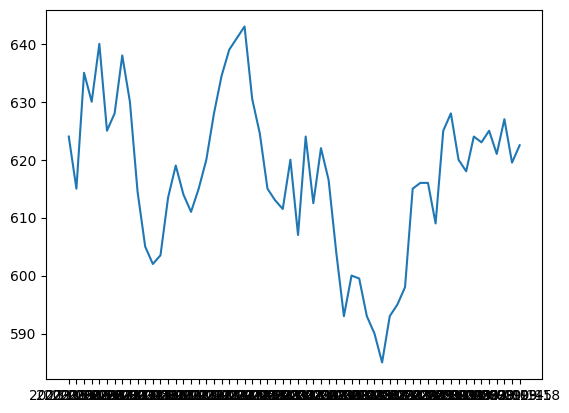

In [2]:
# read and print sample historical stock price data
series = pd.read_csv('../Data/PH-historical-stock-price-data-csv/AC.csv', header = 0, index_col = 'Date')
print(series)

# plot historical stock price data
fig, ax = plt.subplots()    
ax.plot(series['Close'].tail(60))

In [3]:
def trimf(val, vector):
    """
    Triangular membership function
    
    This function calculates the fuzzy value of a crisp input
    
    a <= b <= c
    
    Args
    ----
    
    val:
        crisp value to be fuzzified
        
    vector:
        values of the left base, peak, and right of the triangular membership function
        
    Returns
    -------
        fuzzified value from the crisp value
    """
    
    
    assert len(vector) == 3, "the length of the vector must be equal to 3"
    
    a, b, c = vector
    assert a <= b, "a must be less than or equal to b"
    assert b <= c, "b must be less than or equal to c"
    
    if val <= a:
        return 0
    elif (val >= a) and (val <= b):
        return (val - a)/(b - a)
    elif (val >= b) and (val <= c):
        return (c - val)/(c - b) 
    elif val >= c:
        return 0        

In [4]:
def linearf(val, vector, positive_slope = True):
    """
    a <= b
    
    Parameters
    ----------
    
    val:
        The value to be fuzzified
        
    vector:
        A length 2 vector that defines the linear boundaries of the 
        linear membership function
    
    positive slope:

        
    Returns
    -------
        The fuzzified value from the crisp input
    """
    
    
    assert len(vector) == 2, "The vector must of of length 2"
    
    a, b = vector
    assert a<=b, "a must be less than or equal to be"
    
    if positive_slope:
       if val < a:
           return 0
       elif val > b:
           return 1
       else:
           return (val - a)/(b - a)
    else:
       if val < a:
           return 1
       elif val > b:
           return 0
       else:
           return (b - val)/(b - a) 

In [5]:
class fuzzy_TA:
    def __init__(self, df):
        self.df = df
        self.u = pd.DataFrame()
        self.z = pd.DataFrame()
        self.u_sum = pd.DataFrame()
        self.z_sum = pd.DataFrame()
    
    # MOMENTUM INDICATORS
    
    def RSI(self, window = 14, fillna = False, p0 = 0, p1 = 1):
        """
        Relative Stregth Index
    
        Parameters
        ----

        window:
            the window or number of elements to be included in the calculation
        
        p0:
            the constant to be passed in the consequent of the TSK model
        
        p1:
            the first order value to be passed in the consequent of the TSK model
        
        Returns
        ------
            None
        
        """
        
        # print(f'\n{ticker}')
        
        # compute for the RSI of the stock
        self.df[f'RSI{window}'] = (ta.momentum.RSIIndicator(
            close = self.df['Close'],
            window = window,
            fillna = fillna)
            .rsi()
        )
        
        # compute for the membership values of the RSI values
        self.u[f'RSI{window}_lo'] = self.df[f'RSI{window}'].apply(lambda x: linearf(x, [0, 50], positive_slope = False))
        self.u[f'RSI{window}_md'] = self.df[f'RSI{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'RSI{window}_hi'] = self.df[f'RSI{window}'].apply(lambda x: linearf(x, [50, 100], positive_slope = True))
        
        # the following are the fuzzy rules for RSI
        # if RSI is low, then buy
        self.z[f'RSI{window}_lo'] = p0 + (p1 * ((self.u[f'RSI{window}_lo'] * 25)  + 75))
        
        # # if RSI is medium, then hold
        mask = (self.df[f'RSI{window}'] < 50)
        self.z.loc[mask, f'RSI{window}_md'] = p0 + (p1 * ((self.u[f'RSI{window}_md'] * -25) + 75))
        
        mask = (self.df[f'RSI{window}'] > 50)
        self.z.loc[mask, f'RSI{window}_md'] = p0 + (p1 * ((self.u[f'RSI{window}_md'] * 25) + 25))

        # if RSI is high then sell
        self.z[f'RSI{window}_hi'] = p0 + (p1 * ((self.u[f'RSI{window}_hi'] * -25) + 25))
        
    def StochRSI(self, window = 14, smooth1 = 3, smooth2 = 3, fillna = False, p0 = 0, p1 = 1):
        """
        Stochastic RSI
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        self.df[f'StochRSI{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['Close'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_d()
        )

        # calculate the membership values for low, medium and high RSI
        self.u[f'StochRSI{window}_lo'] = self.df[f'StochRSI{window}'].apply(lambda x: linearf(x, [0, 0.2], positive_slope = False))
        self.u[f'StochRSI{window}_md'] = self.df[f'StochRSI{window}'].apply(lambda x: trimf(x, [0, 0.5, 1])) 
        self.u[f'StochRSI{window}_hi'] = self.df[f'StochRSI{window}'].apply(lambda x: linearf(x, [0.8, 1], positive_slope = True))
        
        # the following are the fuzzy rules for StochRSI
        # if StochRSI is low, then buy
        self.z[f'StochRSI{window}_lo'] = p0 + (p1 * ((self.u[f'StochRSI{window}_lo'] * 25)  + 75))
        
        # if StochRSI is medium and StochRSI is less than 0.5, then buy
        mask = (self.df[f'StochRSI{window}'] < 0.5)
        self.z.loc[mask, f'StochRSI{window}_md'] = p0 + (p1 * ((self.u[f'StochRSI{window}_md'] * -25) + 75))
        
        # if StochRSI is medium and StochRSI is more than 0.5, then sell
        mask = (self.df[f'StochRSI{window}'] > 0.5)
        self.z.loc[mask, f'StochRSI{window}_md'] = p0 + (p1 * ((self.u[f'StochRSI{window}_md'] * 25) + 25))

        # if StochRSI is high then sell
        self.z[f'StochRSI{window}_hi'] = p0 + (p1 * ((self.u[f'StochRSI{window}_hi'] * -25) + 25))
        
    def WilliamsR(self, window = 14, fillna = False, p0 = 0, p1 = 1):
        """
        Compute for the williams R 
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        # compute for Williams % R
        self.df[f'WilliamsR{window}'] = (
            ta.momentum.WilliamsRIndicator(
                high = self.df['High'],
                low = self.df['Low'],
                close = self.df['Close'],
                lbp = window,
                fillna = fillna)
            .williams_r()
        )

        # calculate the membership values for low, medium and high RSI
        self.u[f'WilliamsR{window}_lo'] = self.df[f'WilliamsR{window}'].apply(lambda x: linearf(x, [-100, -80], positive_slope = False))
        self.u[f'WilliamsR{window}_md'] = self.df[f'WilliamsR{window}'].apply(lambda x: trimf(x, [-100, -50, 0])) 
        self.u[f'WilliamsR{window}_hi'] = self.df[f'WilliamsR{window}'].apply(lambda x: linearf(x, [-20, 0], positive_slope = True))
        
        # the following are the fuzzy rules for StochRSI
        # if StochRSI is low, then buy
        self.z[f'WilliamsR{window}_lo'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_lo'] * 25)  + 75))
        
        # if StochRSI is medium and StochRSI is less than 0.5, then buy
        mask = (self.df[f'WilliamsR{window}'] < -50)
        self.z.loc[mask, f'WilliamsR{window}_md'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_md'] * -25) + 75))
        
        # if StochRSI is medium and StochRSI is more than 0.5, then sell
        mask = (self.df[f'WilliamsR{window}'] >= -50)
        self.z.loc[mask, f'WilliamsR{window}_md'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_md'] * 25) + 25))

        # if StochRSI is high then sell
        self.z[f'WilliamsR{window}_hi'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_hi'] * -25) + 25))

    def Ultimate(self, window1 = 7, window2 = 14, window3 = 28, weight1 = 4.0, weight2 = 2.0, weight3 = 1.0, fillna = False, p0 = 0, p1 = 1):
        """
        Ultiimate oscilator
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        # compute for the Ultimate oscillator
        self.df[f'Ultimate{window1}'] = ta.momentum.ultimate_oscillator(
            high = self.df['High'], 
            low = self.df['Low'], 
            close = self.df['Close'], 
            window1 = window1, 
            window2 = window2, 
            window3 = window3, 
            weight1 = weight1, 
            weight2 = weight2, 
            weight3 = weight3, 
            fillna = fillna)
    
        # calculate the membership values for low, medium and high ultimate oscillator
        self.u[f'Ultimate{window1}_lo'] = self.df[f'Ultimate{window1}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'Ultimate{window1}_md'] = self.df[f'Ultimate{window1}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'Ultimate{window1}_hi'] = self.df[f'Ultimate{window1}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for ultimate oscillator
        # if ultimate is low, then buy
        self.z[f'Ultimate{window1}_lo'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_lo'] * 25)  + 75))
        
        # if ultimate is medium and ultimate is below 50 then do this; borderlining to buying
        mask = (self.df[f'Ultimate{window1}'] < 50)
        self.z.loc[mask, f'Ultimate{window1}_md'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_md'] * -25) + 75))
        
        # if ultimate is medium and ultimate is above or equal to  50 then do this; borderlining to selling
        mask = (self.df[f'Ultimate{window1}'] >= 50)
        self.z.loc[mask, f'Ultimate{window1}_md'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_md'] * 25) + 25))

        # if ultimate is high then sell
        self.z[f'Ultimate{window1}_hi'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_hi'] * -25) + 25))

    def TSI(self, window_slow = 25, window_fast = 13, fillna= False, p0 = 0, p1 = 1):
        """
        True Strength Index
        
        Parameters
        ----------
        window_slow:

        window_fast:
        
        fillna:
        
        Returns
        -------        
            None
        """

        # compute for the TSI of the stock
        self.df[f'TSI{window_slow}x{window_fast}'] = (ta.momentum.tsi(
            close = self.df['Close'],
            window_slow = 25,
            window_fast = 13,
            fillna = False)
        )

        # calculate the membership values for low, medium and high ultimate oscillator
        self.u[f'TSI{window_slow}x{window_fast}_lo'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: linearf(x, [-0.5, -0.25], positive_slope = False))
        self.u[f'TSI{window_slow}x{window_fast}_md'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: trimf(x, [-0.5, 0, 0.5])) 
        self.u[f'TSI{window_slow}x{window_fast}_hi'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: linearf(x, [0.25, 0.5], positive_slope = True))


        # the following are the fuzzy rules for ultimate oscillator
        # if TSI is low, then buy
        self.z[f'TSI{window_slow}x{window_fast}_lo'] = p0 + (p1 * ((self.u[f'TSI{window_slow}x{window_fast}_lo'] * 25)  + 75))
        
        # if TSI is medium, then hold
        self.z[f'TSI{window_slow}x{window_fast}_md'] = p0 + (p1 * (50))

        # if TSI is high then sell
        self.z[f'TSI{window_slow}x{window_fast}_hi'] = p0 + (p1 * ((self.u[f'TSI{window_slow}x{window_fast}_hi'] * -25) + 25))


    # VOLUME INDICATORS

    def CMF(self, window = 20, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Chaikin Money Flow
        
        Parameters
        ----------
        
        Returns
        -------
        None
        
        
        """
        
        
        self.df[f'CMF{window}'] = (
            ta.volume.chaikin_money_flow(
                high = self.df['High'], 
                low = self.df['Low'], 
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                window = window, 
                fillna = fillna)
            )

        CMF_val = self.df[f'CMF{window}'].iloc[-1]
        
        # calculate the membership values for low, medium and high CMF
        self.u[f'CMF{window}_lo'] = self.df[f'CMF{window}'].apply(lambda x: linearf(x, [-1, 0], positive_slope = False))
        self.u[f'CMF{window}_md'] = self.df[f'CMF{window}'].apply(lambda x: trimf(x, [-1, 0, 1])) 
        self.u[f'CMF{window}_hi'] = self.df[f'CMF{window}'].apply(lambda x: linearf(x, [0, 1], positive_slope = True))        
        
        # the following are the fuzzy rules for CMF
        # if CMF_val is negative then buy
        self.z[f'CMF{window}_lo'] = p0 + (p1 * ((self.u[f'CMF{window}_lo'] * 25)  + 75))
        
        # if CMF is medium and ultimate is below 0 then do this; borderlining to buying
        mask = (self.df[f'CMF{window}'] < 0)
        self.z.loc[mask, f'CMF{window}_md'] = p0 + (p1 * ((self.u[f'CMF{window}_md'] * -25) + 75))
        
        # if CMF is medium and ultimate is above or equal to  0 then do this; borderlining to selling
        mask = (self.df[f'CMF{window}'] >= 0)
        self.z.loc[mask, f'CMF{window}_md'] = p0 + (p1 * ((self.u[f'CMF{window}_md'] * 25) + 25))

        # if CMF is high then sell
        self.z[f'CMF{window}_hi'] = p0 + (p1 * ((self.u[f'CMF{window}_hi'] * -25) + 25))
        
    def MFI(self, window = 14, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Money Flow Index
        
        Parameters
        ----------
        
        Returns
        -------
        None
        
        
        """
        # calculate the money flow index for the window
        self.df[f'MFI{window}'] = (
            ta.volume.MFIIndicator(
                high = self.df['High'], 
                low = self.df['Low'], 
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                window = window, 
                fillna = fillna)
            .money_flow_index()
        )
        
        # calculate the membership values for low, medium and high MFI
        self.u[f'MFI{window}_lo'] = self.df[f'MFI{window}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'MFI{window}_md'] = self.df[f'MFI{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'MFI{window}_hi'] = self.df[f'MFI{window}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))


        # the following are the fuzzy rules for MFI
        # if CMF_val is negative then buy
        self.z[f'MFI{window}_lo'] = p0 + (p1 * ((self.u[f'MFI{window}_lo'] * 25)  + 75))
        
        # if CMF is medium and ultimate is below 0 then do this; borderlining to buying
        mask = (self.df[f'MFI{window}'] < 0)
        self.z.loc[mask, f'MFI{window}_md'] = p0 + (p1 * ((self.u[f'MFI{window}_md'] * -25) + 75))
        
        # if CMF is medium and ultimate is above or equal to  0 then do this; borderlining to selling
        mask = (self.df[f'MFI{window}'] >= 0)
        self.z.loc[mask, f'MFI{window}_md'] = p0 + (p1 * ((self.u[f'MFI{window}_md'] * 25) + 25))

        # if CMF is high then sell
        self.z[f'MFI{window}_hi'] = p0 + (p1 * ((self.u[f'MFI{window}_hi'] * -25) + 25))
            
    def RSI_OBV(self, window = 14, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Relative Stregth Index as applied on the On Balance Volume
        
    
        Parameters
        ----
        window:
            The window 
        
        p0:
            The constant to be passed in the consequent of the TSK model
        
        p1:
            The first order value to be passed in the consequent of the TSK model
        
        Returns
        ------
            None
        
        """

        # compute for OBV
        self.df['OBV'] = (
            ta.volume.OnBalanceVolumeIndicator(
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                fillna = False)
            .on_balance_volume()
        )

        # normalize OBV
        volume_sum = self.df['OBV'].sum()
        self.df['OBV'] = (self.df['OBV']/volume_sum)*100

        # compute for the RSI of the stock
        self.df[f'RSI_OBV{window}'] = (
            ta.momentum.RSIIndicator(
                close = self.df['OBV'], 
                window = window, 
                fillna = fillna)
            .rsi()
        )
        
        # calculate the membership values for low, medium and high RSI_OBV
        self.u[f'RSI_OBV{window}_lo'] = self.df[f'RSI_OBV{window}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'RSI_OBV{window}_md'] = self.df[f'RSI_OBV{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'RSI_OBV{window}_hi'] = self.df[f'RSI_OBV{window}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for RSI_OBV
        # if RSI_OBV is low then buy
        self.z[f'RSI_OBV{window}_lo'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_lo'] * 25)  + 75))
        
        # if RSI_OBV is medium and RSI_OBV is below 50 then do this; borderlining to buying
        mask = (self.df[f'RSI_OBV{window}'] < 50)
        self.z.loc[mask, f'RSI_OBV{window}_md'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_md'] * -25) + 75))
        
        # if RSI_OBV is medium and RSI_OBV is above or equal to  50 then do this; borderlining to selling
        mask = (self.df[f'RSI_OBV{window}'] >= 50)
        self.z.loc[mask, f'RSI_OBV{window}_md'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_md'] * 25) + 25))

        # if RSI_OBV is high then sell
        self.z[f'RSI_OBV{window}_hi'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_hi'] * -25) + 25))
        
    # VOLATILITY INDICATORS
    def BB_pband(self, window = 20, window_dev = 2, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Bolinger percentage band
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        self.df[f'BB_pband{window}'] = (ta.volatility.bollinger_pband(
            close = self.df['Close'], 
            window = window, 
            window_dev = window_dev, 
            fillna = fillna)
        )

        
        # calculate the membership values for low, medium and high RSI
        self.u[f'BB_pband{window}_lo'] = self.df[f'BB_pband{window}'].apply(lambda x: linearf(x, [-0.2, 0], positive_slope = False))
        self.u[f'BB_pband{window}_md'] = self.df[f'BB_pband{window}'].apply(lambda x: trimf(x, [0, 0.5, 1])) 
        self.u[f'BB_pband{window}_hi'] = self.df[f'BB_pband{window}'].apply(lambda x: linearf(x, [1, 1.2], positive_slope = True))
        

        # the following are the fuzzy rules for BB_pband
        # if BB_pband is low then buy
        self.z[f'BB_pband{window}_lo'] = p0 + (p1 * ((self.u[f'BB_pband{window}_lo'] * 25) + 75))
        
        # if BB_pband is low
        mask = self.df[f'BB_pband{window}'] < 0
        # if BB_pband is less than 0, then lean towards buying
        self.z.loc[mask, f'BB_pband{window}_md'] = p0 + (p1 * ((self.u[f'BB_pband{window}_md'] * -25) + 75))

        mask = self.df[f'BB_pband{window}'] >= 0
        # if BB_pband is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'BB_pband{window}_md'] = p0 + (p1 * ((self.u[f'BB_pband{window}_md'] * 25) + 25))

        # if BB_pband is high then sell
        self.z[f'BB_pband{window}_hi'] = p0 + (p1 * ((self.u[f'BB_pband{window}_hi'] * -25) + 25))
        
    # TREND INDICATORS
    
    def CCI(self, window = 20, constant = 0.0015, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Compute for the commodity channel index
        """
        # compute for the commodity channel index
        self.df[f'CCI{window}'] = (
            ta.trend.CCIIndicator(
                high = self.df['High'],
                low = self.df['Low'],
                close = self.df['Close'],
                window = window,
                constant = constant,
                fillna = fillna)
            .cci()
        )

    
        # calculate the membership values for low, medium and high CCI
        self.u[f'CCI{window}_lo'] = self.df[f'CCI{window}'].apply(lambda x: linearf(x, [-200, -100], positive_slope = False))
        self.u[f'CCI{window}_md'] = self.df[f'CCI{window}'].apply(lambda x: trimf(x, [-200, 0, 200])) 
        self.u[f'CCI{window}_hi'] = self.df[f'CCI{window}'].apply(lambda x: linearf(x, [100, 200], positive_slope = True))
        
        # the following are the fuzzy rules for CCI
        # if BB_pband is low then buy
        self.z[f'CCI{window}_lo'] = p0 + (p1 * ((self.u[f'CCI{window}_lo'] * 25) + 75))
        
        # if CCI is low
        mask = self.df[f'CCI{window}'] < 0
        # if CCI is less than 0, then lean towards buying
        self.z.loc[mask, f'CCI{window}_md'] = p0 + (p1 * ((self.u[f'CCI{window}_md'] * -25) + 75))

        mask = self.df[f'CCI{window}'] >= 0
        # if CCI is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'CCI{window}_md'] = p0 + (p1 * ((self.u[f'CCI{window}_md'] * 25) + 25))

        # if CCI is high then sell
        self.z[f'CCI{window}_hi'] = p0 + (p1 * ((self.u[f'CCI{window}_hi'] * -25) + 25))
    
    def STC(self, window_slow = 50, window_fast = 30, cycle = 30, smooth1 = 3, smooth2 = 3, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1, ticker = 'ticker'):
        """
        Schaff Trend Cycle
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        self.df[f'STC{window_slow}'] = (
            ta.trend.STCIndicator(
                close = self.df['Close'],
                window_slow = window_slow,
                window_fast = window_fast,
                cycle = cycle,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stc()
        )
        
        # calculate the membership values for low, medium and high CCI
        self.u[f'STC{window_slow}_lo'] = self.df[f'STC{window_slow}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'STC{window_slow}_md'] = self.df[f'STC{window_slow}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'STC{window_slow}_hi'] = self.df[f'STC{window_slow}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for CCI
        # if BB_pband is low then buy
        self.z[f'STC{window_slow}_lo'] = p0 + (p1 * ((self.u[f'STC{window_slow}_lo'] * 25) + 75))
        
        # if CCI is low
        mask = self.df[f'STC{window_slow}'] < 50
        # if CCI is less than 0, then lean towards buying
        self.z.loc[mask, f'STC{window_slow}_md'] = p0 + (p1 * ((self.u[f'STC{window_slow}_md'] * -25) + 75))

        mask = self.df[f'STC{window_slow}'] >= 50
        # if CCI is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'STC{window_slow}_md'] = p0 + (p1 * ((self.u[f'STC{window_slow}_md'] * 25) + 25))

        # if CCI is high then sell
        self.z[f'STC{window_slow}_hi'] = p0 + (p1 * ((self.u[f'STC{window_slow}_hi'] * -25) + 25))
        
    def PSAR(self, step = 0.02, max_step = 0.2, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Parabolic SAR
        
        Parameters
        ----------
        
        step:   float
            lorem ipsum
            
        max_step:   float
            lorem ipsum
            
        fillna: bool
            lorem ipsum
        
        p0: float
            lorem ipsum
        
        p1: float
            lorem ipsum
        
        Returns
        -------
        None
        """
        
        # parabolic SAR
        self.df[f'PSAR{step}{max_step}'] = (ta.trend.PSARIndicator(
            high = self.df['High'],
            low = self.df['Low'],
            close = self.df['Close'],
            step = step,
            max_step = max_step,
            fillna = fillna)
            .psar()
        )
        
        # conditions for buy
        condition_1 = self.df[f'PSAR{step}{max_step}'].iloc[-2] > self.df['Close'].iloc[-2]
        condition_2 = self.df[f'PSAR{step}{max_step}'].iloc[-1] < self.df['Close'].iloc[-1]
         
        if condition_1 & condition_2:
            self.u[f'PSAR{step}{max_step}_buy'] = 1
            self.z[f'PSAR{step}{max_step}_buy'] = 100
        elif (not condition_1) & (not condition_2):
            self.u[f'PSAR{step}{max_step}_sell'] = 1
            self.z[f'PSAR{step}{max_step}_sell'] = 0
        else:
            self.u[f'PSAR{step}{max_step}_hold'] = 1
            self.z[f'PSAR{step}{max_step}_hold'] = 50 

    # OTHER INDICATORS
    
    def Fisher_trans(self, window: int = 14, smooth2: int = 3, adjust: bool = True, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Fisher Transform
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        
        """
        
        np.seterr(divide='ignore')

        med = (self.df['High'] + self.df['Low']) / 2
        ndaylow = med.rolling(window=window).min()
        ndayhigh = med.rolling(window=window).max()
        raw = (2 * ((med - ndaylow) / (ndayhigh - ndaylow))) - 1
        smooth = raw.ewm(span=5, adjust=adjust).mean()
        _smooth = smooth.fillna(0)
        
        self.df[f'Fisher{window}'] = (
            (np.log((1 + _smooth) / (1 - _smooth)))
            .ewm(span=3, adjust=adjust)
            .mean()
        )
        
        # calculate the membership values for low, medium and high Fisher
        self.u[f'Fisher{window}_lo'] = self.df[f'Fisher{window}'].apply(lambda x: linearf(x, [-4, 0], positive_slope = False))
        self.u[f'Fisher{window}_md'] = self.df[f'Fisher{window}'].apply(lambda x: trimf(x, [-2, 0, 2])) 
        self.u[f'Fisher{window}_hi'] = self.df[f'Fisher{window}'].apply(lambda x: linearf(x, [0, 4], positive_slope = True))
        
        # the following are the fuzzy rules for Fisher
        # if Fisher is low, then buy
        self.z[f'Fisher{window}_lo'] = p0 + (p1 * ((self.u[f'Fisher{window}_lo'] * 25)  + 75))
        
        # if Fisher is medium and Fisher is less than 0.5, then buy
        mask = (self.df[f'StochRSI{window}'] < 0)
        self.z.loc[mask, f'Fisher{window}_md'] = p0 + (p1 * ((self.u[f'Fisher{window}_md'] * -25) + 75))
        
        # if Fisher is medium and Fisher is more than 0.5, then sell
        mask = (self.df[f'StochRSI{window}'] >= 0)
        self.z.loc[mask, f'Fisher{window}_md'] = p0 + (p1 * ((self.u[f'Fisher{window}_md'] * 25) + 25))

        # if Fisher is high then sell
        self.z[f'Fisher{window}_hi'] = p0 + (p1 * ((self.u[f'Fisher{window}_hi'] * -25) + 25))
    
    def z_total(self):
        """
        Computes for the total z value for the consequent of the Tsukamoto model
        
        Parameters
        ----------
        
        self
        
        Returns
        -------
        z_total
            the consequent in the Takagi-Sugeno-Kang/Tsukamoto fuzzy inference model
        
        """
        
        self.u_sum['sum'] = self.u.sum(axis = 1)
        
        # initialize z_sum to be 0
        self.z['z_sum'] = 0
        
        # add all values of z across different technical indicator
        for col_name in self.u.columns:
            # produce mask that would remove NANs in the dataframe
            mask = ~(self.z['z_sum'] + (self.z[f'{col_name}'] * self.u[f'{col_name}'])).isna()
            # apply mask
            self.z.loc[mask, 'z_sum'] = self.z['z_sum'] + (self.z[f'{col_name}'] * self.u[f'{col_name}'])
        
        # compute for the normalized z_sum by u_sum
        self.df['z_sum'] = self.z['z_sum'] / self.u_sum['sum']
            
        return 0
    

                z_sum  z_sum_rolling  z_sum_ewm
Date                                           
2023-08-18  72.600350      67.127485  67.952031
2023-08-22  76.543896      69.865491  70.099997
2023-08-23  72.648147      71.189597  70.737034
2023-08-24  70.587184      71.437406  70.699572
2023-08-25  68.557927      71.765836  70.164161
2023-08-29  52.861680      69.462557  65.838541
2023-08-30  50.171500      66.281526  61.921780
2023-08-31  46.381962      62.536042  58.036826
2023-09-01  45.848979      58.151054  54.989864
2023-09-04  40.637354      53.578084  51.401737
2023-09-05  32.537142      48.142364  46.685588
2023-09-06  29.562205      42.571546  42.404742
2023-09-07  29.743619      39.268966  39.239461
2023-09-08  27.493701      36.029280  36.303021
2023-09-11  28.195378      33.431197  34.276111
2023-09-12  26.783283      30.707526  32.402904
2023-09-13  28.679859      28.999313  31.472142
2023-09-14  25.932870      28.055845  30.087324
2023-09-15  30.098442      28.132450  30

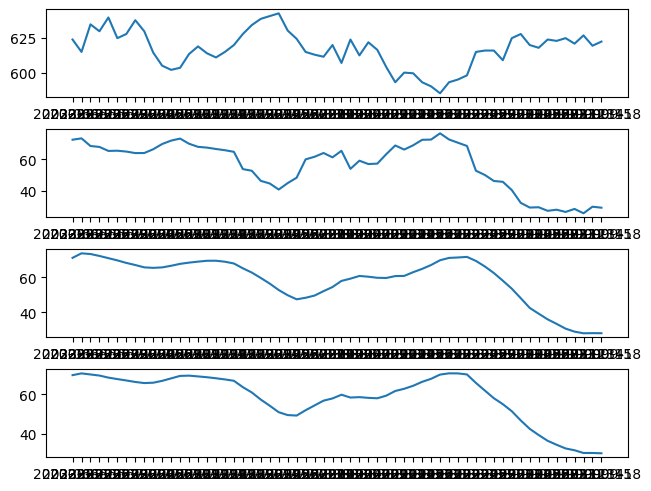

In [6]:
stock = fuzzy_TA(series)

# momentum indicators
stock.RSI()
stock.StochRSI()
stock.WilliamsR()
stock.Ultimate()
stock.TSI()

# volume indicator
stock.CMF()
stock.MFI()
stock.RSI_OBV()

# volatility indicator
stock.BB_pband()

# trend indicators
stock.CCI()
stock.STC()
stock.PSAR()

# other indicator
stock.Fisher_trans()

# compute for the total value of z
stock.z_total()
stock.df['z_sum_rolling']=stock.df['z_sum'].rolling(7).mean()
stock.df['z_sum_ewm'] = stock.df['z_sum'].ewm(span=7).mean()
print(stock.df[['z_sum', 'z_sum_rolling', 'z_sum_ewm']].tail(20))

# plot the z values
fig, axs = plt.subplots(4, 1, layout='constrained')
axs[0].plot(series['Close'].tail(60))
axs[1].plot(stock.df['z_sum'].tail(60))
axs[2].plot(stock.df['z_sum_rolling'].tail(60))
axs[3].plot(stock.df['z_sum_ewm'].tail(60))
plt.show()


Date
2023-09-18    285.236437
Name: change, dtype: float64 Date
2023-09-18    51.491452
Name: returns, dtype: float64


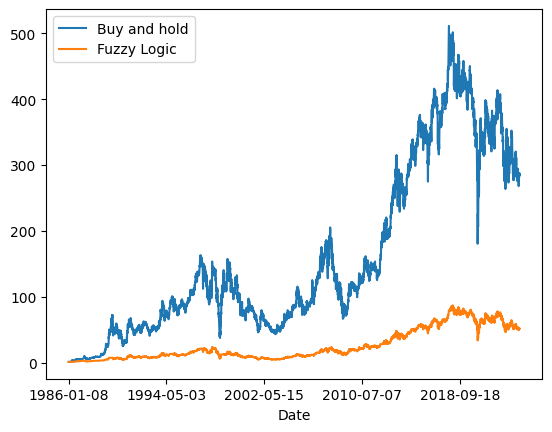

In [11]:
stock.df['returns'] = 1
stock.df['change'] = stock.df['Close'].pct_change()+1
stock.df['regime'] = 0
has_long_position = False
buy_price = 0
buy_index = 0
for i in range(0, len(stock.df)-1):
    if (stock.df['z_sum_ewm'][i] >= 50) and has_long_position == False:
        # buy stock in the next day
        stock.df['regime'][i+1] = 1
        buy_price = stock.df['Close'][i+1]
        has_long_position = True
    
    condition1 = (100*(stock.df['Close'][i] - buy_price)/buy_price) < - 5
    condition2 = stock.df['z_sum_ewm'][i] <= 20
    if ( (condition1) or (condition2) ) and has_long_position == True:
        stock.df['regime'][i] = -1
        has_long_position = False
    # print(stock.df['z_sum_rolling'][i]>50,'\t\t', stock.df['z_sum_rolling'][i],'\t\t',stock.df['regime'][i],'\t\t',stock.df['Close'][i],'\t\t', 100*(stock.df['Close'][i] - buy_price)/buy_price)   
for i in range(1, len(stock.df)):
    if stock.df['regime'][i-1] == 1 and stock.df['regime'][i] == 0:
        stock.df['regime'][i] = 1

for i in range(0, len(stock.df)):
    if stock.df['regime'][i] != 0:
        stock.df['returns'][i] = stock.df['change'][i]
        
stock.df['change'].cumprod().plot(label = 'Buy and hold')
stock.df['returns'].cumprod().plot(label = 'Fuzzy Logic').legend()

print(stock.df['change'].cumprod()[-1:], stock.df['returns'].cumprod()[-1:])